In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import shap

# Load the data
data = pd.read_csv('Housing.csv')

In [2]:
# Display the first few rows and basic information about the dataset
data.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
data.describe()

price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000

The dataset contains **545 entries with 13 columns**, with numeric and categorical data types. 

The descriptive statistics reveal:
 - Mean price is approximately 4.77 million
 - Prices range from 1.75 million to 13.3 million
 - 50% of properties are priced between 3.43-5.74 million

Also some insights from the properties characteristcs are:
 - Area ranges from 1,650 to 16,200 square units
 - Most homes have 2-3 bedrooms (mean: 2.97)
 - Bathrooms range from 1-4 (mean: 1.29)
 - Stories range from 1-4 (mean: 1.81)
 - Parking spaces range from 0-3 (mean: 0.69)

Data is clean with **no missing values.**

### Preprocess the data

In [5]:
# Convert categorical variables to numeric
data['mainroad'] = data['mainroad'].map({'yes': 1, 'no': 2})
data['guestroom'] = data['guestroom'].map({'yes': 1, 'no': 2})
data['basement'] = data['basement'].map({'yes': 1, 'no': 2})
data['hotwaterheating'] = data['hotwaterheating'].map({'yes': 1, 'no': 2})
data['airconditioning'] = data['airconditioning'].map({'yes': 1, 'no': 2})
data['prefarea'] = data['prefarea'].map({'yes': 1, 'no': 2})

# One-hot encode the 'furnishingstatus' column
#data = pd.get_dummies(data, columns=['furnishingstatus'])
#data_encoded = pd.get_dummies(data, columns=['furnishingstatus']).astype(int)

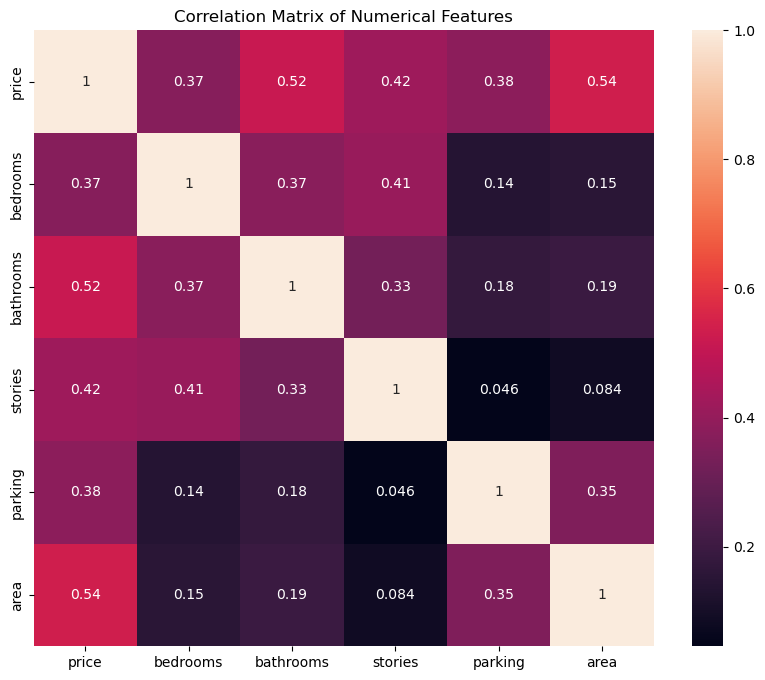

In [6]:
# Correlation matrix for numerical features
# Define numerical features
numerical_features = ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'area']
corr_matrix = data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#No multicollinearity issues

The heatmap suggests that while several features correlate with price, none show extremely strong correlations (>0.8) that would indicate multicollinearity issues.

The moderate correlations between price and various features support their usefulness in the prediction model, while the varying correlation strengths between features suggest they each contribute unique information to the model.

In [7]:
x1 = data['area']
x2 = data['bedrooms']
x3 = data['bathrooms']
x4  = data['stories']
x5 = data['mainroad']
x6 = data['guestroom']
x7 = data['basement']
x8 = data['hotwaterheating']
x9 = data['airconditioning']
x10 = data['parking']
x11 = data['prefarea']
x12 = data['furnishingstatus']

y = data['price']

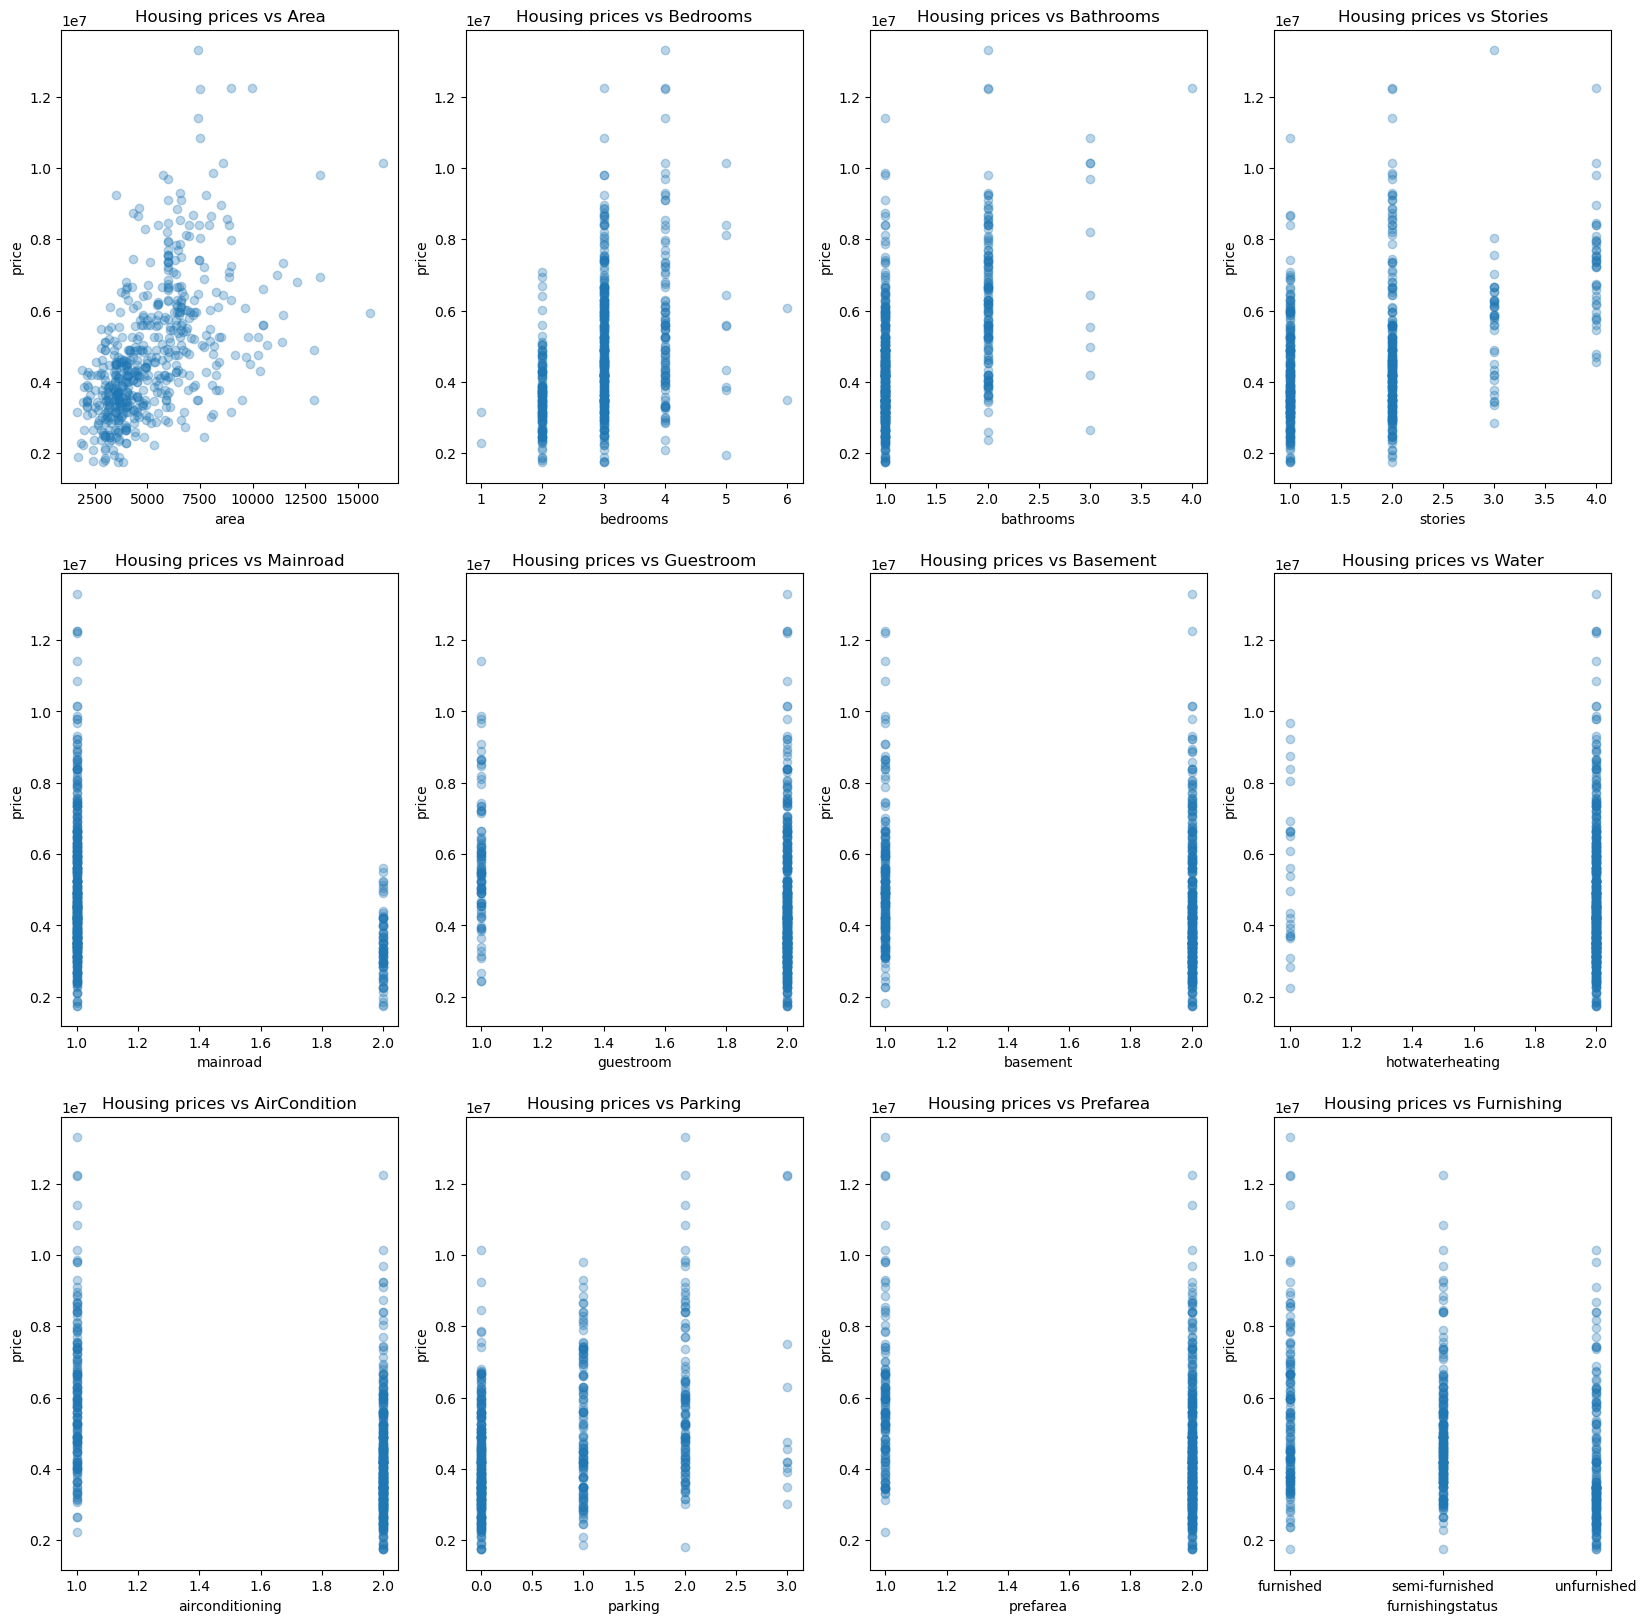

In [8]:
figure, axis = plt.subplots(3,4, figsize = (20,20))

size = 12
al = 0.3

axis[0,0].scatter(x1, y, alpha = al)
axis[0,0].set_title('Housing prices vs Area', fontsize = size)
axis[0,0].set_xlabel('area')
axis[0,0].set_ylabel('price')

axis[0,1].scatter(x2, y, alpha = al)
axis[0,1].set_title('Housing prices vs Bedrooms', fontsize = size)
axis[0,1].set_xlabel('bedrooms')
axis[0,1].set_ylabel('price')

axis[0,2].scatter(x3, y, alpha = al)
axis[0,2].set_title('Housing prices vs Bathrooms', fontsize = size)
axis[0,2].set_xlabel('bathrooms')
axis[0,2].set_ylabel('price')

axis[0,3].scatter(x4, y, alpha = al)
axis[0,3].set_title('Housing prices vs Stories', fontsize = size)
axis[0,3].set_xlabel('stories')
axis[0,3].set_ylabel('price')

axis[1,0].scatter(x5, y, alpha = al)
axis[1,0].set_title('Housing prices vs Mainroad', fontsize = size)
axis[1,0].set_xlabel('mainroad')
axis[1,0].set_ylabel('price')

axis[1,1].scatter(x6, y, alpha = al)
axis[1,1].set_title('Housing prices vs Guestroom', fontsize = size)
axis[1,1].set_xlabel('guestroom')
axis[1,1].set_ylabel('price')

axis[1,2].scatter(x7, y, alpha = al)
axis[1,2].set_title('Housing prices vs Basement', fontsize = size)
axis[1,2].set_xlabel('basement')
axis[1,2].set_ylabel('price')

axis[1,3].scatter(x8, y, alpha = al)
axis[1,3].set_title('Housing prices vs Water', fontsize = size)
axis[1,3].set_xlabel('hotwaterheating')
axis[1,3].set_ylabel('price')

axis[2,0].scatter(x9, y, alpha = al)
axis[2,0].set_title('Housing prices vs AirCondition', fontsize = size)
axis[2,0].set_xlabel('airconditioning')
axis[2,0].set_ylabel('price')

axis[2,1].scatter(x10, y, alpha = al)
axis[2,1].set_title('Housing prices vs Parking', fontsize = size)
axis[2,1].set_xlabel('parking')
axis[2,1].set_ylabel('price')

axis[2,2].scatter(x11, y, alpha = al)
axis[2,2].set_title('Housing prices vs Prefarea', fontsize = size)
axis[2,2].set_xlabel('prefarea')
axis[2,2].set_ylabel('price')

axis[2,3].scatter(x12, y, alpha = al)
axis[2,3].set_title('Housing prices vs Furnishing', fontsize = size)
axis[2,3].set_xlabel('furnishingstatus')
axis[2,3].set_ylabel('price')

plt.show()

Area
 - Shows the strongest positive correlation with price
 - Clear upward trend but with increasing variance at higher areas

Bedrooms, Bathrooms, Stories
 - All show positive relationships with price

Parking
 - Gradual increase in price with more parking spaces

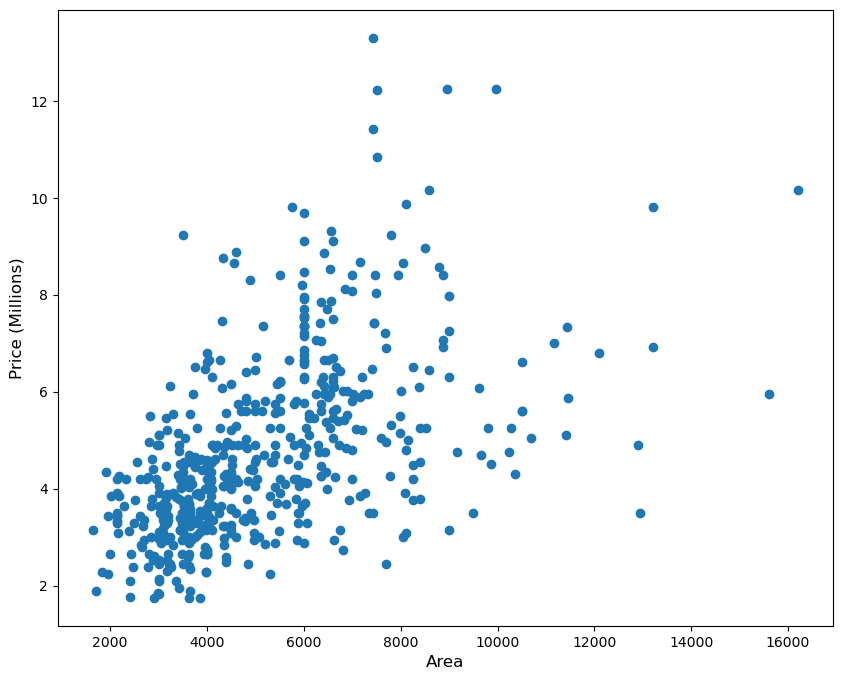

In [9]:
#scatter plot area/price
plt.figure(figsize=(10, 8))
plt.ylabel('Price (Millions)', fontsize=12)
plt.xlabel('Area', fontsize=12)

plt.scatter(data['area'],data['price'] / 1_000_000)
plt.show()

 - Several outliers in the upper price range (10-13 million) with varying areas
 - Price dispersion increases with property area, suggesting other factors influence prices of larger properties

Segmentation approach may be sensible. The idea is to 
 - Split the model into different price ranges
 - Train separate models for luxury properties (>8000 area) and standard properties
 - We observe different pricing dynamics in each segment

In [10]:
data = pd.get_dummies(data, columns=['furnishingstatus'])

# Modeling

In [11]:
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 Score: {r2}")
print(f"RMSE Score: {rmse}")

R2 Score: 0.6115124458248049
RMSE Score: 1401298.5522061335


The Random Forest model achieved an **R² score of 0.611**, indicating that it **explains about 61.1% of the variance in housing prices**. This suggests a moderate predictive performance, as the model captures more than half of the price variations but still leaves room for improvement.

The **Root Mean Square Error** is approximately 1.4 million euros. 
Given that the price range in the dataset is from 1.75 million to 13.3 million:

 - For a dataset with such a wide price spread (approximately 12 million), this level of error suggests the **model struggles with accurately predicting extreme values**
 - The error is particularly significant for lower-priced properties. For example
   - Actual price: 2 million
   - Model prediction could range from: 0.6 to 3.4 million
   - The error is proportionally larger here (could be off by up to 70% of the house value)






In [12]:
# Feature importance analysis from the Random Forest model
feature_importance = pd.DataFrame({'Features': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)

                           Features  Importance
0                              area    0.468234
2                         bathrooms    0.150226
8                   airconditioning    0.062535
9                           parking    0.056240
3                           stories    0.056193
1                          bedrooms    0.047031
13     furnishingstatus_unfurnished    0.033974
6                          basement    0.032065
10                         prefarea    0.030034
7                   hotwaterheating    0.017215
5                         guestroom    0.015012
11       furnishingstatus_furnished    0.012021
4                          mainroad    0.009939
12  furnishingstatus_semi-furnished    0.009279


 - **Area is by far the most important predictor**, with an importance score of 0.468 (about 47% of the total importance, area being the most important factor makes sense).
 - Bathrooms comes second at 0.150 (15% importance)
 - Air conditioning, parking, and stories each contribute around 5-6% to the predictions

In [13]:
# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap_importance = pd.DataFrame({'Features': X.columns, 'Shap Scores': np.abs(shap_values).mean(axis=0)})
shap_importance = shap_importance.sort_values('Shap Scores', ascending=False)
print(shap_importance)

                           Features    Shap Scores
0                              area  803392.867847
2                         bathrooms  494937.443152
8                   airconditioning  271563.841130
13     furnishingstatus_unfurnished  198847.816695
10                         prefarea  146065.583295
3                           stories  132641.330034
6                          basement  130714.667992
9                           parking  130068.388380
1                          bedrooms  109575.348285
4                          mainroad   50027.817827
5                         guestroom   34754.828045
7                   hotwaterheating   27655.029254
11       furnishingstatus_furnished   24429.567124
12  furnishingstatus_semi-furnished   14524.379105


**Both methods agree on the most influential features**


In [14]:
# Evaluate model performance with different feature subsets
def evaluate_model(X, y, features):
    X_subset = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse

# Evaluate model performance with different feature subsets
results = []
for method in ['Importance', 'Shap Method']:
    importance_df = feature_importance if method == 'Importance' else shap_importance
    for n in [3, 5, 7, 10, 13]:
        top_features = importance_df['Features'].head(n).tolist()
        r2, rmse = evaluate_model(X, y, top_features)
        results.append([f"{method} - Top {n}", r2, rmse])

results_df = pd.DataFrame(results, columns=['Method', 'R2', 'RMSE Score:'])
print(results_df)

# Evaluate different scaling methods
scalers = [
    ('Default Model', None),
    ('Standard Sc', StandardScaler()),
    ('MinMax Sc', MinMaxScaler()),
    ('Robust Sc', RobustScaler())
]

scaling_results = []
for name, scaler in scalers:
    if scaler:
        pipeline = Pipeline([('scaler', scaler), ('rf', RandomForestRegressor(n_estimators=100, random_state=42))])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
    else:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scaling_results.append([name, r2, rmse])

scaling_results_df = pd.DataFrame(scaling_results, columns=['Method', 'R2', 'RMSE Score:'])
print(scaling_results_df)

                 Method        R2   RMSE Score:
0    Importance - Top 3  0.433883  1.691591e+06
1    Importance - Top 5  0.548697  1.510345e+06
2    Importance - Top 7  0.552963  1.503190e+06
3   Importance - Top 10  0.591635  1.436700e+06
4   Importance - Top 13  0.612081  1.400274e+06
5   Shap Method - Top 3  0.433883  1.691591e+06
6   Shap Method - Top 5  0.494680  1.598179e+06
7   Shap Method - Top 7  0.555518  1.498888e+06
8  Shap Method - Top 10  0.586558  1.445604e+06
9  Shap Method - Top 13  0.613031  1.398558e+06
          Method        R2   RMSE Score:
0  Default Model  0.611512  1.401299e+06
1    Standard Sc  0.611550  1.401231e+06
2      MinMax Sc  0.612327  1.399829e+06
3      Robust Sc  0.611858  1.400675e+06


The results demonstrate **how the model performs with different numbers of top features:**
 - **Performance improves consistently as features are added** until reaching 13 features (We won't drop any features, we need to find even more to improve performance)
 - **R² scores are nearly identical** between methods (**Importance vs SHAP Method**) at each feature count
 - **Scaling also has minimal impact** on model performance, with all methods producing very similar R² and RMSE scores. 


# Segmentation

Let's apply the segmentation approach and split the dataset into luxury (>8000 area) and standard (≤8000 area) segments

In [15]:
# Split data into luxury and standard segments
luxury_data = data[data['area'] > 8000]
standard_data = data[data['area'] <= 8000]

In [16]:
def train_segment_model(segment_data, segment_name):
    # Split the data into features and target
    X = segment_data.drop('price', axis=1)
    y = segment_data['price']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions and evaluate
    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{segment_name} Segment Results:")
    print(f"R2 Score: {r2}")
    print(f"RMSE Score: {rmse}")
    
    
    return r2, rmse

In [17]:
# Train and evaluate models for each segment
luxury_results = train_segment_model(luxury_data, "Luxury Properties")
standard_results = train_segment_model(standard_data, "Standard Properties")


Luxury Properties Segment Results:
R2 Score: 0.2855007220537147
RMSE Score: 1877264.1120191372

Standard Properties Segment Results:
R2 Score: 0.658026211300512
RMSE Score: 1164473.3454471466


--------------------------------------------------------------------------------------------------------------------------------------------------------

For **Standard Properties (≤8000 area)**
 - R² Score: 0.655 (65.5% variance explained)
 - RMSE Score: 1,164,164

Demonstrates **better prediction accuracy compared to the Luxury properties segment, and to the combined model**

Also, more consistent pricing patterns in standard properties

The segmentation approach reveals **limitations in predicting luxury property prices** that weren't apparent in the combined model

This suggests that **different or additional features might be needed, to better predict luxury property prices**, while the model works reasonably well for standard properties.

# Drop outliers

<Axes: ylabel='price'>

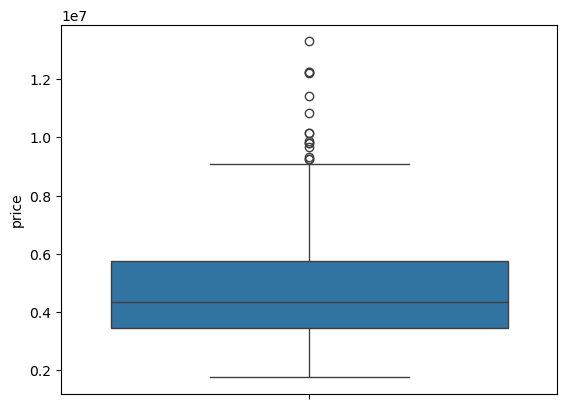

In [18]:
sns.boxplot(data['price'])

<Axes: ylabel='price'>

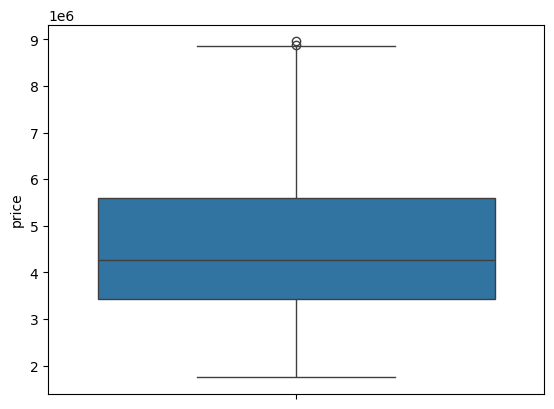

In [19]:
threshold_2 = 9000000
removed_outliers_2 = data[data['price'] <= threshold_2] 
sns.boxplot(removed_outliers_2['price'])

In [20]:
X = removed_outliers_2.drop(columns='price')
y = removed_outliers_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)


scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators= 200, max_depth= 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_final = r2_score(y_test, y_pred)
rmse_final = root_mean_squared_error(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
mae_final_perc = mean_absolute_percentage_error(y_test, y_pred)

print(f"Model's R2 score: {round(r2_final, 2)}")
print('-----------------------------------------')
print(f"Model's RMSE scores: {round(rmse_final, 2)}")



Model's R2 score: 0.66
-----------------------------------------
Model's RMSE scores: 1036855.17


------------------------------------------------------------------------------------------------------------------------------------------------------------------

The R² score increased to 0.67 over previous results

RMSE decreased substantially, indicating better prediction accuracy


The removal of outliers has clearly improved the model's predictive power, making it more reliable for typical housing price predictions. 

# Segmentation and drop outliers approach

In [21]:
# Split data into luxury and standard segments
luxury_data = removed_outliers_2[removed_outliers_2['area'] > 8000]
standard_data = removed_outliers_2[removed_outliers_2['area'] <= 8000]

In [22]:
# Train and evaluate models for each segment
luxury_results = train_segment_model(luxury_data, "Luxury Properties")
standard_results = train_segment_model(standard_data, "Standard Properties")


Luxury Properties Segment Results:
R2 Score: 0.14108591211028265
RMSE Score: 1368368.6258936222

Standard Properties Segment Results:
R2 Score: 0.6957494869835912
RMSE Score: 950871.5083958772


------------------------------------------------------------------------------------------------------------------------------------------------------------------

The R² score increased to 0.695 over previous results

RMSE decreased substantially, indicating better prediction accuracy


The removal of outliers in combination with the segmentation approach,  improved the model's predictive power.

The decreased R² score and RMSE Score in Luxury Properties Segment Results was totally logical due to the removal of outliers

# cross-validation approach for RandomForest, GradientBoosting, Ridge and Lasso comparison

In [24]:
# Define the models
models = [
    RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42),
    GradientBoostingRegressor(random_state=42),
    Ridge(alpha=10, random_state=42),
    Lasso(alpha=1.5, random_state=42)
]

# Define KFold cross-validation
k = 15  # Number of folds
cv = KFold(n_splits=k, random_state=42, shuffle=True)

# Perform cross-validation for each model
for model in models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    for fold, R2 in enumerate(scores, 1):
        print(f"Fold {fold} R2: {R2:.4f}")
    
    # Calculate and print the average R2 and its standard deviation
    print(f"\nAverage R2 for {type(model).__name__}: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")
    print("\n")

Fold 1 R2: 0.5561
Fold 2 R2: 0.5688
Fold 3 R2: 0.7735
Fold 4 R2: 0.7606
Fold 5 R2: 0.4198
Fold 6 R2: 0.6437
Fold 7 R2: 0.5507
Fold 8 R2: 0.6660
Fold 9 R2: -0.0809
Fold 10 R2: 0.6377
Fold 11 R2: 0.7482
Fold 12 R2: 0.6498
Fold 13 R2: 0.6416
Fold 14 R2: 0.6758
Fold 15 R2: 0.6358

Average R2 for RandomForestRegressor: 0.5898 (+/- 0.3989)


Fold 1 R2: 0.6596
Fold 2 R2: 0.6155
Fold 3 R2: 0.8168
Fold 4 R2: 0.7653
Fold 5 R2: 0.4587
Fold 6 R2: 0.6051
Fold 7 R2: 0.5677
Fold 8 R2: 0.6643
Fold 9 R2: -0.2551
Fold 10 R2: 0.5937
Fold 11 R2: 0.6727
Fold 12 R2: 0.7258
Fold 13 R2: 0.6170
Fold 14 R2: 0.6344
Fold 15 R2: 0.5820

Average R2 for GradientBoostingRegressor: 0.5816 (+/- 0.4767)


Fold 1 R2: 0.5792
Fold 2 R2: 0.6986
Fold 3 R2: 0.7949
Fold 4 R2: 0.7720
Fold 5 R2: 0.5159
Fold 6 R2: 0.5851
Fold 7 R2: 0.6443
Fold 8 R2: 0.5937
Fold 9 R2: -0.2813
Fold 10 R2: 0.5913
Fold 11 R2: 0.6432
Fold 12 R2: 0.7759
Fold 13 R2: 0.5580
Fold 14 R2: 0.6489
Fold 15 R2: 0.6747

Average R2 for Ridge: 0.5863 (+/- 0.4908)


All models have similar R² score but **Random Forest has the smallest standard deviation.**